# Cartograms

In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm

In [35]:
# Helper function to read in a data text file, sort data by state,
# and write the sorted numeric data to a binary file.
def load_data(feature):
    state_names = []
    feature_values = []
    f = open("data/"+feature+".txt","r")
    header = f.readline()
    for i,line in enumerate(f):
        a = line.split()
        if len(a) == 2:
            state_names += [a[0]]
        elif len(a) == 3:
            state_names += [a[0]+" "+a[1]]
        else:
            print("Encountered invalid line (%d): %s"%(i+1,a))
            break
        feature_values += [float(a[-1])]
    f.close()
    sort_indices = [i for (s,i) in sorted((s,i) for (i,s) in enumerate(state_names))]
    feature_values = np.array(feature_values)[sort_indices]
    feature_values.astype('float').tofile(feature+".bin")
    print("Saved numeric data to '%s.bin'"%feature)
    return header

In [36]:
# Helper function to make a truncated colormap.
def make_colormap(colormap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=colormap.name, a=minval, b=maxval),
        colormap(np.linspace(minval, maxval, n)))
    return new_cmap

# Helper function to make a plot of a map with associated colorbar.
def plot_map(data, colormap, white_edges, feature_transform=None):
    # Shift and rescale data.
    norm_data = data - np.min(data)
    norm_data /= np.max(norm_data)
    
    # Apply colormap to create a color image.
    im = (255.*colormap(norm_data)[:,:,:3]).astype(np.uint8)
    im[data==0]=255.
    m,n,p = im.shape

    # detect edges.
    dx, dy = np.gradient(norm_data)
    dr = np.sqrt(dx*dx+dy*dy)
    if white_edges:
        im[dr>0]=255.
    else:
        im[dr>0]=0.
        
    if feature_transform:
        f = np.fromfile(feature_transform+"_fields.bin")
        u = f[:m*n].reshape((m,n))
        X = f[m*n:2*m*n].reshape((m,n))
        Y = f[2*m*n:].reshape((m,n))
        X = np.stack([X,Y], axis=-1)
        cart = np.zeros((m,n,p),dtype=np.uint8)
        for i in range(m):
            for j in range(n):
                i2=int(X[i,j,0]+0.5)
                j2=int(X[i,j,1]+0.5)
                if i2<0: i2=0
                elif i2>m-1: i2=m-1
                if j2<0: j2=0
                elif j2>n-1: j2=n-1
                cart[i,j,:]=im[i2,j2,:]
        im = cart
        
    # Visualize the map with edges.
    fig, ax = plt.subplots(1,1,figsize=(24,16))
    ax.imshow(im)
    ax.axis('off')
    return fig, ax

# Add a colorbar.
def add_cbar(data, fig, ax, colormap):
    cnorm = colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    sm = cm.ScalarMappable(cmap=colormap, norm=cnorm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.05, shrink=0.7)
    return cbar
    
# Helper function to make a map given a data size and feature.
def populate_map(size, feature):
    if size == 'large':
        m=816; n=1216
    elif size == 'med':
        m=408; n=608
    else:
        m=204; n=304
    feature_values = np.fromfile(feature+".bin")
    state_labels = np.fromfile(size+".bin", dtype=np.uint8).reshape((m,n))
    
    # Set values in each state.
    feature_map = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            if state_labels[i,j]>0:
                feature_map[i,j] = feature_values[state_labels[i,j]-1]
    return feature_map # return a map with feature values populated in each state.

Saved numeric data to 'elevation.bin'


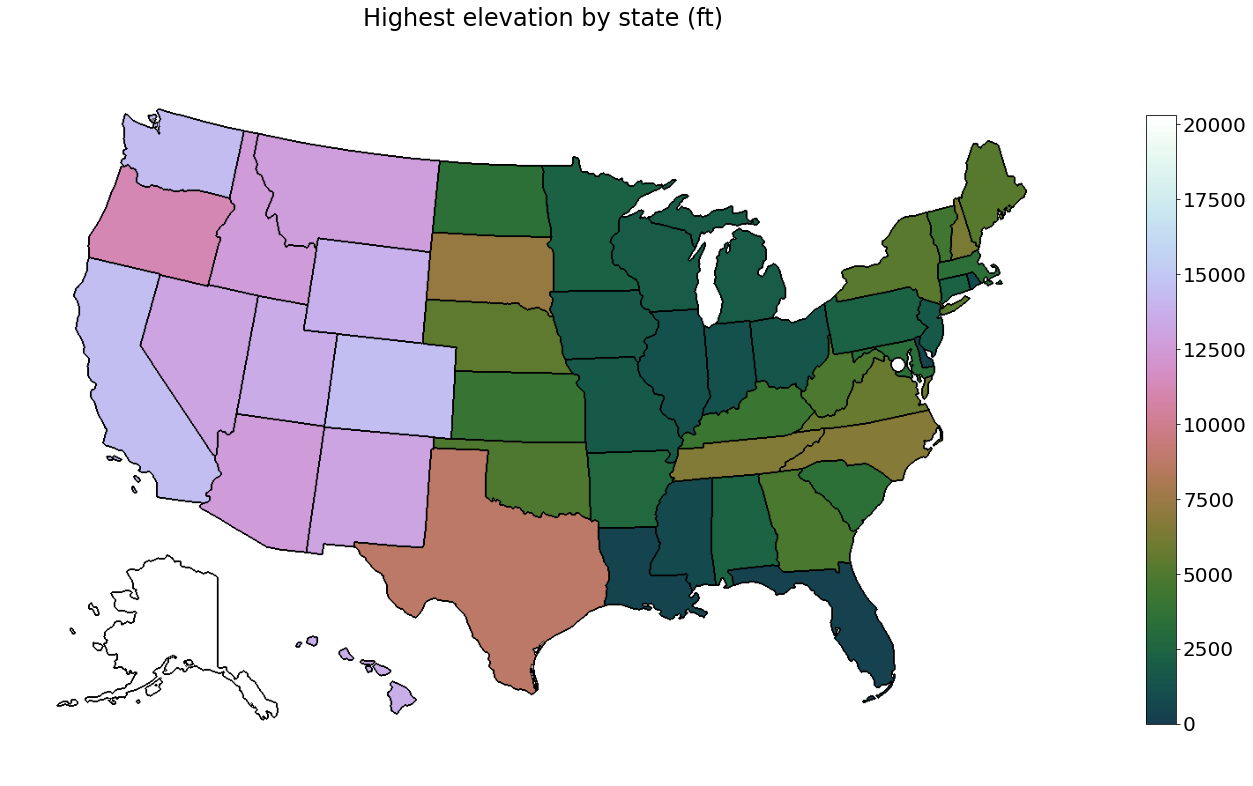

In [44]:
# Select a dataset to work with
feature = 'elevation'
header = load_data(feature) # returns the header of our dataset, which can be used as a title.

# Select a data size ('small', 'med', or 'large'),
# and choose colormap and edge color settings.
size = 'small'
colormap = make_colormap(plt.cm.cubehelix, 0.2, 1.)
white_edges = False

 # Populate a US map given the map size and feature.
feature_map = populate_map(size, feature)
fig, ax = plot_map(feature_map, colormap, white_edges) # plot the map
cbar = add_cbar(feature_map, fig, ax, colormap)        # add a corresponding colorbar

# Set size and labels for plot.
ax.set_title(header, size=24)
cbar.ax.tick_params(labelsize=20)
plt.show()

In [45]:
# Once we are happy with the image, we can save to a file.
fig.tight_layout()
fig.savefig("images/"+feature+"_map_"+size+".png")

In [46]:
# compile the cartogram script.
!g++ -O3 -Wall -ansi -pedantic -fopenmp -o cartogram cartogram.cc

In [47]:
# Run the diffusion simulation to generate a mapping for the cartogram.
out = !./cartogram $size $feature
print(out[0])
print(out[1])

Integrated to T=21445 using 21662 steps.
Elapsed time: 27.87823 min.


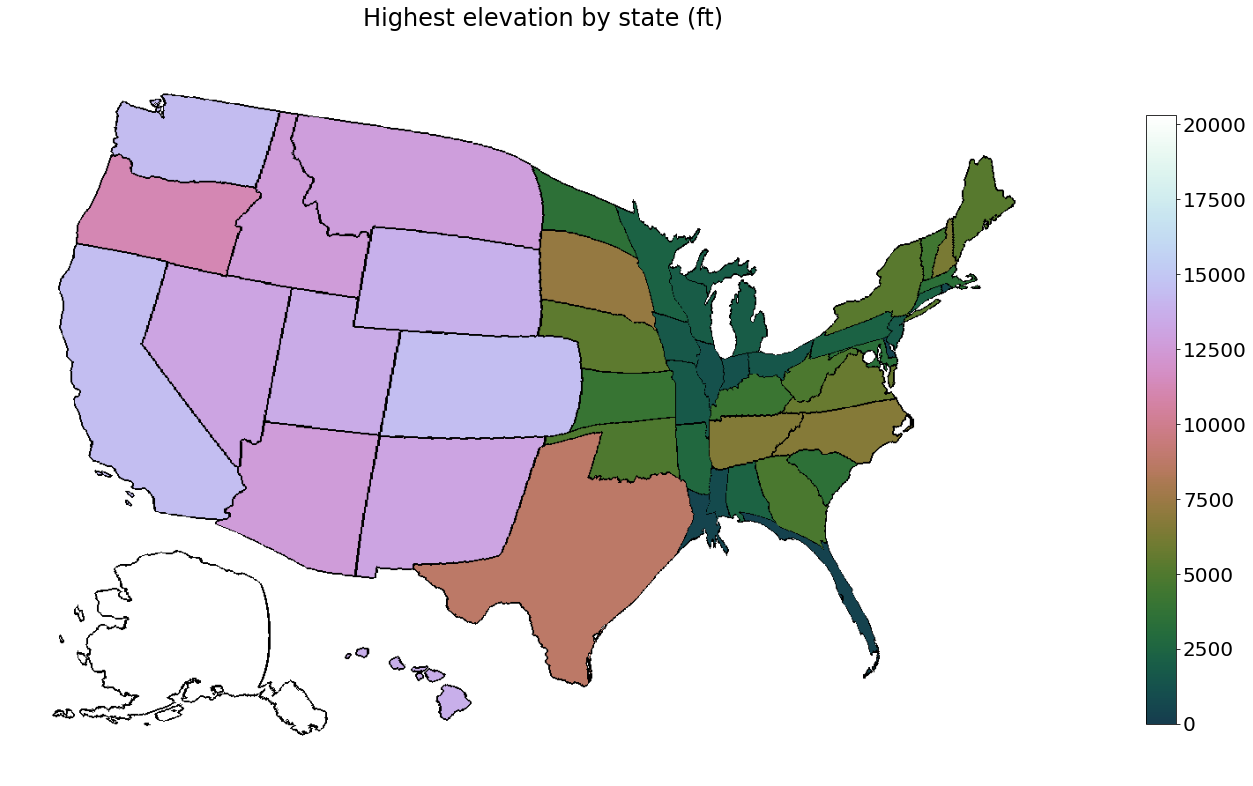

In [50]:
# Plot the same map with deformation mapping applied:
fig, ax = plot_map(feature_map, colormap, white_edges, feature_transform=feature)
cbar = add_cbar(feature_map, fig, ax, colormap)
ax.set_title(header, size=24)
cbar.ax.tick_params(labelsize=20)
plt.show()

In [51]:
# Save to a file.
fig.tight_layout()
fig.savefig("images/"+feature+"_cartogram_"+size+".png")